**Author**: Justine Debelius<br>
**Date**: Summer/Fall 2021<br>
**Conda enviroment**: `micc-2021.11`<br>

I want to start the analysis by checking the intraindividual diversity and verifying that a person is more similar to themself than they are to anyone else.

In [1]:
import os

from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import skbio
import statsmodels.api as sms
import statsmodels.formula.api as smf
import seaborn as sn

from qiime2 import Artifact, Metadata, Visualization

import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.deicode.actions as q2_deicode

rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
# rcParams['pdf.fonttype'] = 42
# rcParams['pdf.use14corefonts'] = True

np.set_printoptions(precision=5)

%matplotlib inline

In [2]:
meta_q2 = Metadata.load('data/metadata_paired.tsv')
meta = meta_q2.to_dataframe()
meta['long_survival'] = meta['long_survival'].astype(int)

I want to start by checking intra individual relationship with alpha diversity.

In [3]:
alpha_metrics = np.sort([os.path.splitext(fp)[0] for fp in os.listdir('data/diversity/alpha/')])
alpha = {
    metric.split(".")[0]: Artifact.load(f'data/diversity/alpha/{metric}.qza')
    for metric in alpha_metrics
}
alpha_df = pd.concat(axis=1, objs=[
    meta,
    pd.DataFrame({metric: art.view(pd.Series) for metric, art in alpha.items()})
])
alpha_df['observed_features'] = \
    ((alpha_df['observed_features'] - alpha_df['observed_features'].mean()) / alpha_df['observed_features'].std())

In [4]:
alpha_df.sort_values(['host_subject_id', 'tissue_type'], inplace=True)

In [5]:
alpha_correlations = pd.DataFrame({metric: scipy.stats.spearmanr(
    *alpha_df.groupby('tissue_type')[metric].apply(lambda x: x.values).values)
    for metric in np.hstack([list(alpha.keys()), 'depth'])
}).T
alpha_correlations.columns = ['R2', 'p-value']
alpha_correlations

,R2,p-value
observed_features,0.672613,1.329902e-14
shannon,0.741037,8.035409e-19
simpson,0.738567,1.202042e-18
depth,0.533857,8.983543e-09


In [6]:
alpha_df.sort_values(['host_subject_id', 'tissue_type'], inplace=True)
normal = alpha_df.loc[alpha_df['tissue_type'] == 'normal'].set_index('host_subject_id').copy()
tumor = alpha_df.loc[alpha_df['tissue_type'] == 'tumor'].set_index('host_subject_id').copy()


In [7]:
alpha_df.sort_values(['host_subject_id', 'tissue_type'], inplace=True)
meta_paired = pd.concat(axis=1, objs=[
    alpha_df.drop_duplicates('host_subject_id', keep='last').drop(
            columns=np.hstack(['tissue_type','depth', alpha_metrics])),
    alpha_df.groupby('host_subject_id')[np.hstack(['depth', alpha_metrics])].diff().dropna(),
]).set_index('host_subject_id')
# meta_paired = pd.concat(axis=1, objs=[
#     meta_paired, 
#     dist_delta.loc[dist_delta['hsi0'] == dist_delta['hsi1']].set_index('hsi0')[beta_metrics],
# ])
meta_paired.index.set_names('subject-id', inplace=True)

Then, I also want to check the intra verse inter individual beta diversity.

In [8]:
beta_metrics = ['unweighted_unifrac', 'weighted_unifrac', 'braycurtis', 
           'aitchison', 'jaccard']
beta = {
    metric: Artifact.load(f'data/diversity/beta/{metric}.qza'.replace("_", '-'))
    for metric in beta_metrics
}
beta = {
    metric: q2_diversity.filter_distance_matrix(dm, metadata=Metadata(meta)
                                               ).filtered_distance_matrix
    for metric, dm in beta.items()
}

In [9]:
dist_delta = pd.DataFrame(
    data={
        metric: dm.view(skbio.DistanceMatrix).filter(meta.index).to_series()
        for metric, dm in beta.items()
    }
)
dist_delta.index.set_names(['sample0', 'sample1'], inplace=True)
dist_delta.reset_index(inplace=True)
dist_delta['hsi0'] = meta.loc[dist_delta['sample0'], 'host_subject_id'].reset_index(drop=True)
dist_delta['hsi1'] = meta.loc[dist_delta['sample1'], 'host_subject_id'].reset_index(drop=True)
dist_delta['tissue0'] =  meta.loc[dist_delta['sample0'], 'tissue_type'].reset_index(drop=True)
dist_delta['tissue1'] =  meta.loc[dist_delta['sample1'], 'tissue_type'].reset_index(drop=True)
dist_delta['location0'] =  meta.loc[dist_delta['sample0'], 'ana_location'].reset_index(drop=True)
dist_delta['location1'] =  meta.loc[dist_delta['sample1'], 'ana_location'].reset_index(drop=True)
dist_delta['year0'] =  meta.loc[dist_delta['sample1'], 'surgery_year'].reset_index(drop=True)
dist_delta['year1'] =  meta.loc[dist_delta['sample1'], 'surgery_year'].reset_index(drop=True)
dist_delta['survival0'] =  meta.loc[dist_delta['sample1'], 'long_survival'].reset_index(drop=True)
dist_delta['survival1'] =  meta.loc[dist_delta['sample1'], 'long_survival'].reset_index(drop=True)

dist_delta['hsi_in'] = (dist_delta['hsi0'] == dist_delta['hsi1'])
dist_delta['tissue_in'] = (
    (dist_delta['tissue0'] == dist_delta['tissue1']) & 
     (dist_delta['location0'] == dist_delta['location1']) & 
     (dist_delta['survival0'] == dist_delta['survival1']) &
    (dist_delta['year0'] == dist_delta['year1'])
)
dist_delta.loc[dist_delta['hsi_in'], 'in_tissue_comp'] = 'same indv'
dist_delta.loc[dist_delta['tissue_in'], 'in_tissue_comp'] = 'same tissue'

Now that we have a paired sample dataframe, we can start to look at the effects of within and between diversity. 

In [10]:
def test_permutation_dist(res_col, beta_cols): 
    """..."""
    split_values = shuffle_labels.groupby(res_col)
    p_values = pd.DataFrame({
        col_: pd.Series(
            scipy.stats.f_oneway(*split_values[col_].apply(lambda x: x.values).values), 
            index=pd.MultiIndex.from_arrays(np.array([['f-value', 'p-value'], [res_col] * 2]), 
                                            names=['group', 'stat'])
        )
        for col_ in beta_cols
    })
    return p_values

In [11]:
inside_comp = dist_delta[np.hstack(['in_tissue_comp', list(beta.keys())])].copy()
inside_comp.dropna(subset=['in_tissue_comp'], inplace=True)
inside_comp = dist_delta[np.hstack(['in_tissue_comp', list(beta.keys())])].copy()
inside_comp.dropna(subset=['in_tissue_comp'], inplace=True)
inside_comp.reset_index(drop=True, inplace=True)
shuffle_labels = pd.DataFrame({
    i: pd.Series(np.random.permutation(inside_comp['in_tissue_comp']))
    for i in np.arange(0, 999)
})
shuffle_labels = pd.concat(axis=1, objs=[inside_comp, shuffle_labels])

perm_res = pd.concat(axis=0, objs=[
    test_permutation_dist(col_, beta_metrics)
    for col_ in shuffle_labels.drop(columns=beta_metrics).columns
])

In [12]:
ori = perm_res.loc[('p-value', 'in_tissue_comp')]
perms = perm_res.loc['p-value'].drop('in_tissue_comp')
p = (1 + (perms <= ori).sum()) / (len(perms) + 1)
p

unweighted_unifrac    0.001
weighted_unifrac      0.001
braycurtis            0.001
aitchison             0.001
jaccard               0.001
dtype: float64

In [13]:
p

unweighted_unifrac    0.001
weighted_unifrac      0.001
braycurtis            0.001
aitchison             0.001
jaccard               0.001
dtype: float64

In [14]:
alpha_df.sort_values(['host_subject_id', 'tissue_type'], inplace=True)
normal = alpha_df.loc[alpha_df['tissue_type'] == 'normal'].set_index('host_subject_id').copy()
tumor = alpha_df.loc[alpha_df['tissue_type'] == 'tumor'].set_index('host_subject_id').copy()


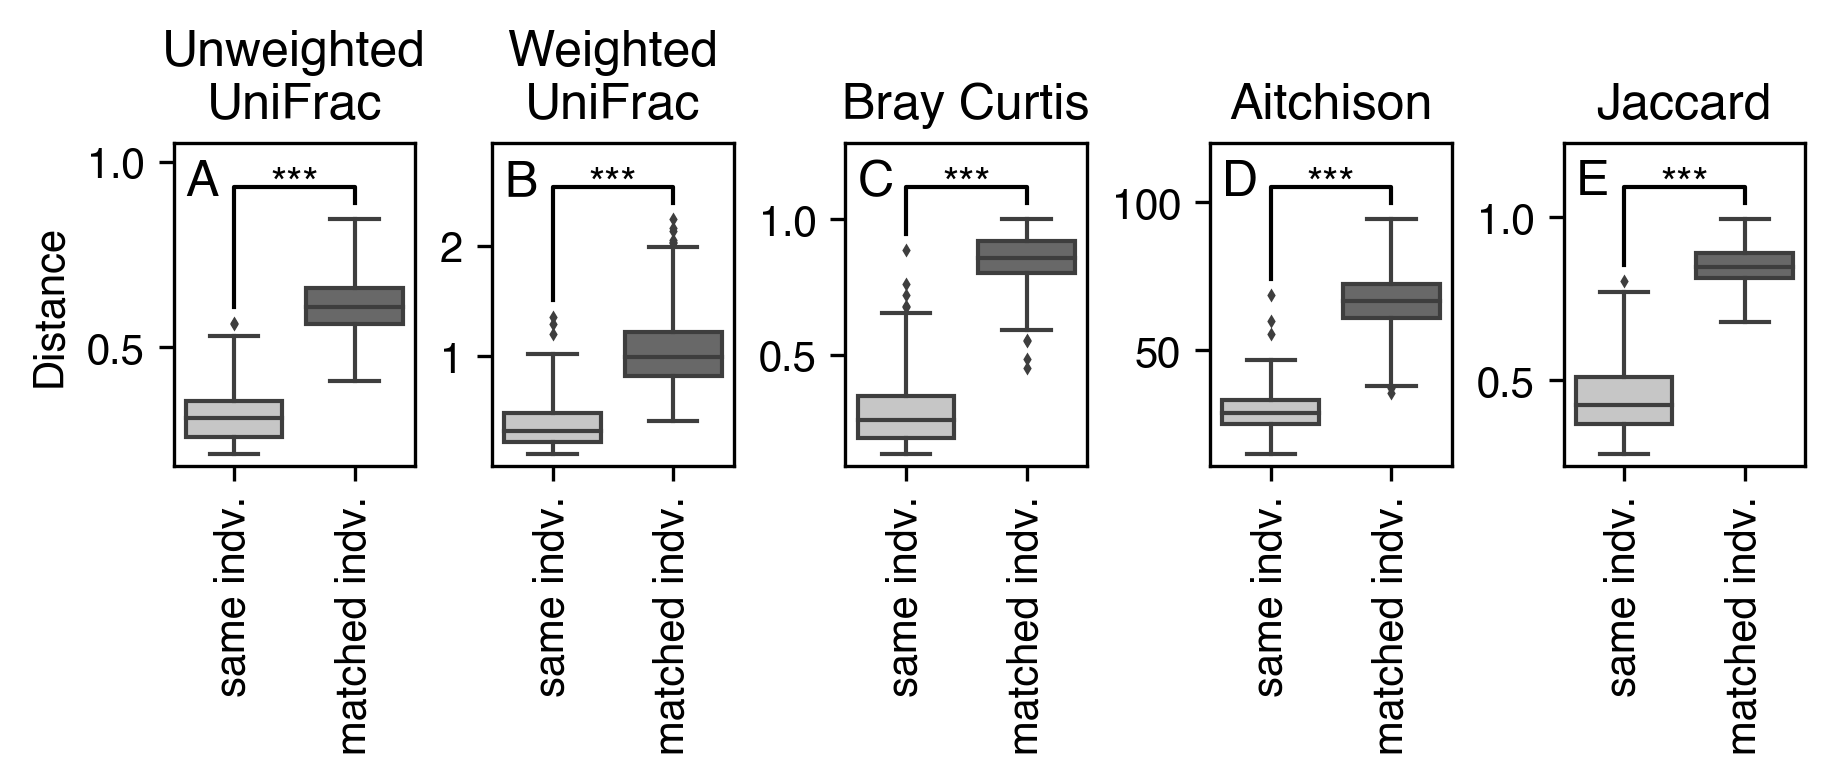

In [15]:
fig_s1 = plt.figure(constrained_layout=True, dpi=300, facecolor='None', figsize=(6, 2.5))
gs_s1 = fig_s1.add_gridspec(1, 1)

gs_s1_beta = gs_s1[0, :].subgridspec(1, len(beta.keys()))
for i, metric in enumerate(beta.keys()):
    ax = fig_s1.add_subplot(gs_s1_beta[i])
    sn.boxplot(x='in_tissue_comp', 
               y=metric, 
               data=dist_delta,
               palette='Greys',
               linewidth=1,
               fliersize=1,
               whis=2,
               )
    ax.set_xlabel('')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_xticklabels(['same indv.', 'matched indv.'])
    if i == 0:
        ax.set_ylabel('Distance')
    else:
        ax.set_ylabel('')
    ax.set_title(metric.replace("_", '\n').replace("yc", 'y c').title().replace("nif", 'niF'))
    ymin, ymax = ax.get_ylim()
    ydelta = (ymax - ymin) * 1.25
    ax.set_ylim(ymin, ymin + ydelta)
    tops = dist_delta.groupby('in_tissue_comp')[metric].max() + 0.05 * ydelta

    ax.plot([0, 0, 1, 1], 
            [tops['same indv'], tops.max() + ydelta * 0.05, tops.max() + ydelta * 0.05, tops['same tissue']],
            'k-',
            linewidth=1,
            )
    ax.text(0.5, tops.max() + ydelta * 0.055, 
            ''.join(['*'] * int(-np.floor(np.log10(p[metric])))),
            ha='center', va='center'
            )
        
    ax.text(x=ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05,
            y=ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95,
            s=list('ABCDEFGH')[i],
            ha='left', va='top',
            size=12
            )

fig_s1.savefig('output/figures/figure_s2_individual_effect.png')
fig_s1.savefig('output/figures/figure_s2_individual_effect.pdf')